# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [6]:
X_train = np.loadtxt("https://raw.githubusercontent.com/kalane15/Mai-ML/refs/heads/main/hw3/datasets/samsung_har/train/X_train.txt")
y_train = np.loadtxt("https://raw.githubusercontent.com/kalane15/Mai-ML/refs/heads/main/hw3/datasets/samsung_har/train/y_train.txt").astype(int)

X_test = np.loadtxt("https://raw.githubusercontent.com/kalane15/Mai-ML/refs/heads/main/hw3/datasets/samsung_har/test/X_test.txt")
y_test = np.loadtxt("https://raw.githubusercontent.com/kalane15/Mai-ML/refs/heads/main/hw3/datasets/samsung_har/test/y_test.txt").astype(int)

In [6]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [7]:
# Ваш код здесь
X = np.vstack((X_train, X_test))
y= np.concatenate((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [8]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [9]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [11]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [12]:
# Ваш код здесь
pca = PCA(random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [12]:
# Ваш код здесь
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance_ratio_cumsum >= 0.9) + 1
print(n_components)

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [13]:
# Ваш код здесь
first_component_variance = round(pca.explained_variance_ratio_[0] * 100)
print(first_component_variance)

51


Визуализируйте данные в проекции на первые две главные компоненты.

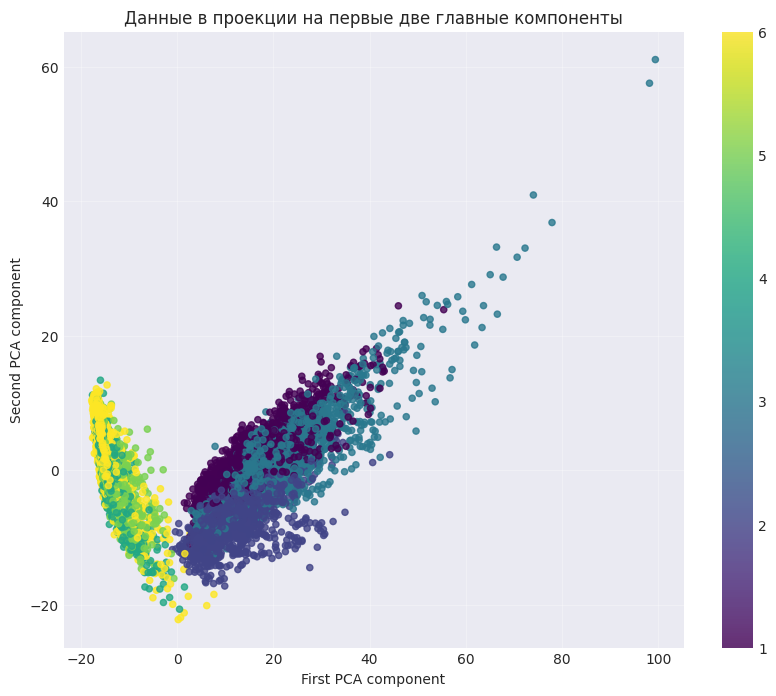

In [14]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis', alpha=0.8)
plt.colorbar(scatter)
plt.xlabel('First PCA component')
plt.ylabel('Second PCA component')
plt.title('Данные в проекции на первые две главные компоненты')
plt.grid(True, alpha=0.3)
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

***2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)***

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [42]:
import numpy as np
import random

class MyKMeans:
    def __init__(self, n_clusters=3, n_init=10, max_iters=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.inertia_ = None
        self.best_inertia_ = None

    def _initialize_centroids(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        return X[indices]

    def _euclidean_distance(self, X, centroids):
        return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    def _assign_clusters(self, X):
        distances = self._euclidean_distance(X, self.centroids)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X, labels):
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                new_centroids[i] = self.centroids[i]
        return new_centroids

    def _compute_inertia(self, X, labels):
        distances = self._euclidean_distance(X, self.centroids)
        return np.sum(np.min(distances, axis=1) ** 2)

    def _single_fit(self, X, init_seed_offset=0):
        if self.random_state is not None:
            np.random.seed(self.random_state + init_seed_offset)

        self.centroids = self._initialize_centroids(X)
        old_inertia = np.inf
        for iteration in range(self.max_iters):
            old_centroids = self.centroids.copy()

            self.labels = self._assign_clusters(X)
            self.centroids = self._compute_centroids(X, self.labels)

            centroid_shift = np.mean(np.linalg.norm(self.centroids - old_centroids, axis=1))
            current_inertia = self._compute_inertia(X, self.labels)
            if abs(current_inertia - old_inertia)  < self.tol:
                break
            old_inertia = current_inertia


        return self.labels.copy(), self.centroids.copy(), current_inertia

    def fit(self, X):
        best_inertia = float('inf')
        best_labels = None
        best_centroids = None

        for init_run in range(self.n_init):
            labels_temp, centroids_temp, inertia_temp = self._single_fit(
                X, init_seed_offset=init_run
            )
            if inertia_temp < best_inertia:
                best_inertia = inertia_temp
                best_labels = labels_temp
                best_centroids = centroids_temp

        self.labels = best_labels
        self.centroids = best_centroids
        self.inertia_ = best_inertia
        self.best_inertia_ = best_inertia

        return self

    def predict(self, X):
        return self._assign_clusters(X)

    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)


In [45]:
custom_kmeans = MyKMeans(
    n_clusters=6,
    n_init=100,
    max_iters=300,
    tol=1e-4,
    random_state=RANDOM_STATE
)

my_labels = custom_kmeans.fit_predict(X_pca)

print("Собственная реализация KMeans:")
print(f"Inertia: {custom_kmeans.best_inertia_:.4f}")

sklearn_kmeans = KMeans(
    n_clusters=6,
    n_init=100,
    random_state=RANDOM_STATE,
    max_iter=300,
    tol=1e-4
)

sklearn_labels = sklearn_kmeans.fit_predict(X_pca)
sklearn_inertia = sklearn_kmeans.inertia_
sklearn_centroids = sklearn_kmeans.cluster_centers_

print("\nSklearn реализация KMeans:")
print(f"Inertia: {sklearn_inertia:.4f}")

KeyboardInterrupt: 

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

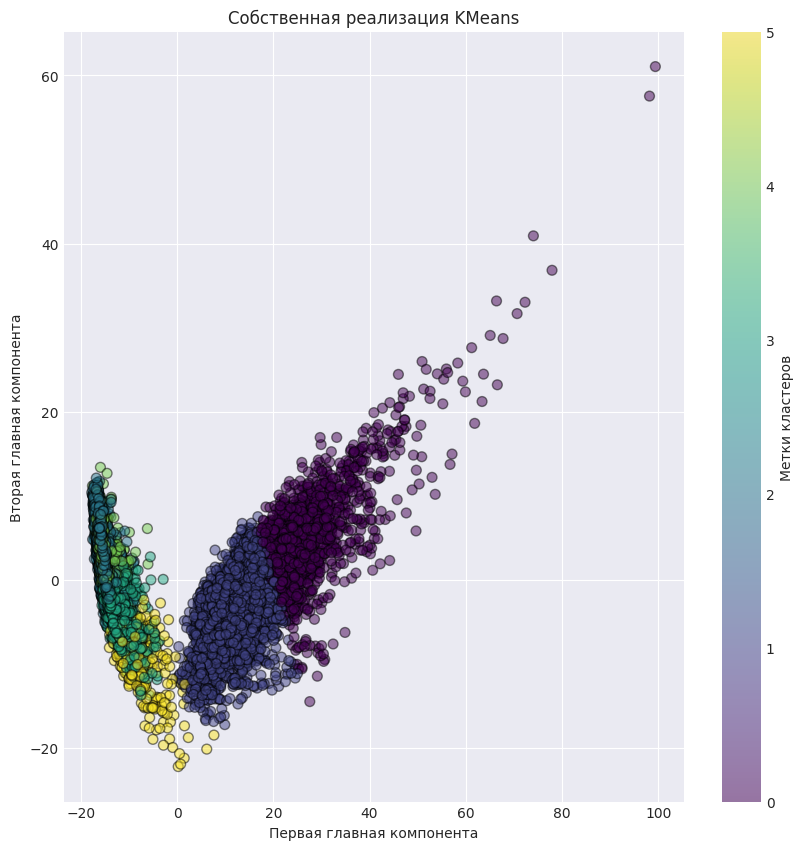

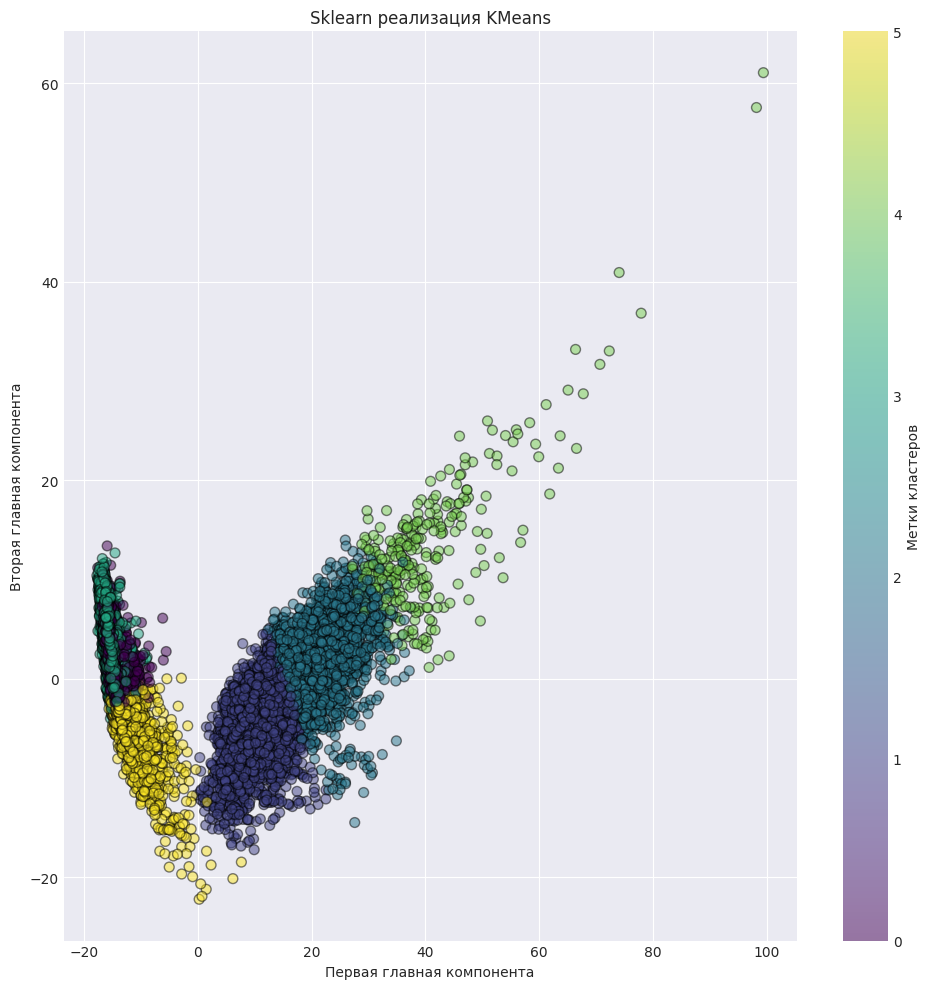

In [40]:
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=my_labels, cmap='viridis', s=50, marker='o', edgecolor='k', alpha=0.5)
plt.title("Собственная реализация KMeans")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.colorbar(label='Метки кластеров')

plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=sklearn_labels, cmap='viridis', s=50, marker='o', edgecolor='k', alpha=0.5)
plt.title("Sklearn реализация KMeans")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.colorbar(label='Метки кластеров')

plt.tight_layout()
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [41]:
tab = pd.crosstab(y, my_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,520,1202,0,0,0,0,1722
подъем вверх по лестнице,157,1383,0,0,0,4,1544
спуск по лестнице,860,546,0,0,0,0,1406
сидение,0,1,68,567,1037,104,1777
стояние,0,0,0,941,929,36,1906
лежание,0,1,1595,122,47,179,1944
все,1537,3133,1663,1630,2013,323,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

У всех перечисленных такая метрика около 0,50, в то время как у лучшего варианта в районе 0,80

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

/tmp/ipython-input-2064294763.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

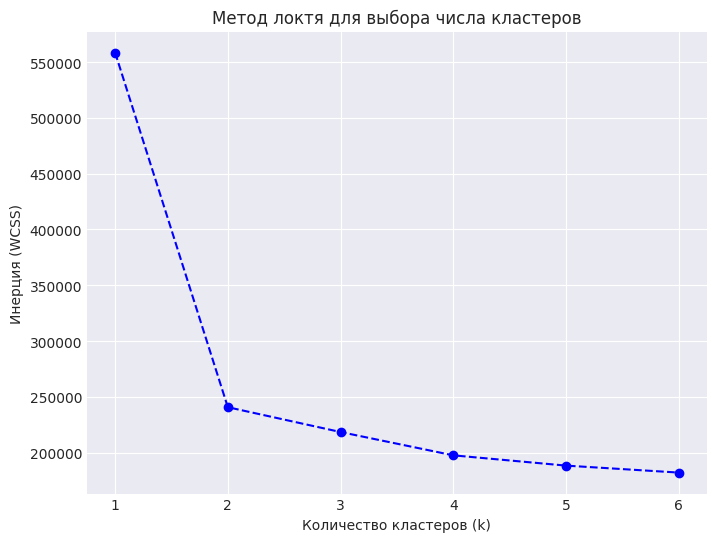

In [36]:
inertia = []


for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, n_classes + 1), inertia, marker='o', linestyle='--', color='b')
plt.title('Метод локтя для выбора числа кластеров')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()


**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [13]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [14]:
# Ваш код здесь
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)

ars_ag = adjusted_rand_score(y, ag.labels_)
ars_kmeans = adjusted_rand_score(y, kmeans.labels_)

print('KMeans ARI: {:.6f}'.format(ars_ag))
print('Agglomerative ARI: {:.6f}'.format(ars_kmeans))

KMeans ARI: 0.459875
Agglomerative ARI: 0.419224


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [17]:
g = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, n_jobs=-1)
g.fit(X_train_scaled, y_train)
best_svc = g.best_estimator_
print(best_svc)

LinearSVC(C=0.1, random_state=17)
0.9379785010699506


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [18]:
y_predicted = best_svc.predict(X_test_scaled)

In [19]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

In [34]:
precision = {}
recall = {}

for activity in tab.index[:-1]:
    TP = tab.loc[activity, activity]
    FP = tab.loc[:, activity].sum() - TP
    FN = tab.loc[activity, :].sum() - TP

    if TP + FP > 0:
        precision[activity] = TP / (TP + FP)
    else:
        precision[activity] = 0

    if TP + FN > 0:
        recall[activity] = TP / (TP + FN)
    else:
        recall[activity] = 0

worst_precision_class = min(precision, key=precision.get)
worst_recall_class = min(recall, key=recall.get)

print("\nТочность для каждого класса:")
for activity, value in precision.items():
    print(f"{activity}: {value:.4f}")

print("\nПолнота для каждого класса:")
for activity, value in recall.items():
    print(f"{activity}: {value:.4f}")


Точность для каждого класса:
ходьба: 0.4862
подъем вверх по лестнице: 0.4893
спуск по лестнице: 0.5000
сидение: 0.4819
стояние: 0.4389
лежание: 0.5000

Полнота для каждого класса:
ходьба: 0.4980
подъем вверх по лестнице: 0.4873
спуск по лестнице: 0.4917
сидение: 0.4338
стояние: 0.4859
лежание: 0.4898


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [39]:
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

gpca = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, n_jobs=-1)
gpca.fit(X_train_pca, y_train)
best_svc = gpca.best_estimator_
y_predicted = best_svc.predict(X_test_pca)

best_score = g.best_score_
best_score_pca = gpca.best_score_

print(round(best_score - best_score_pca, 2))

0.04


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

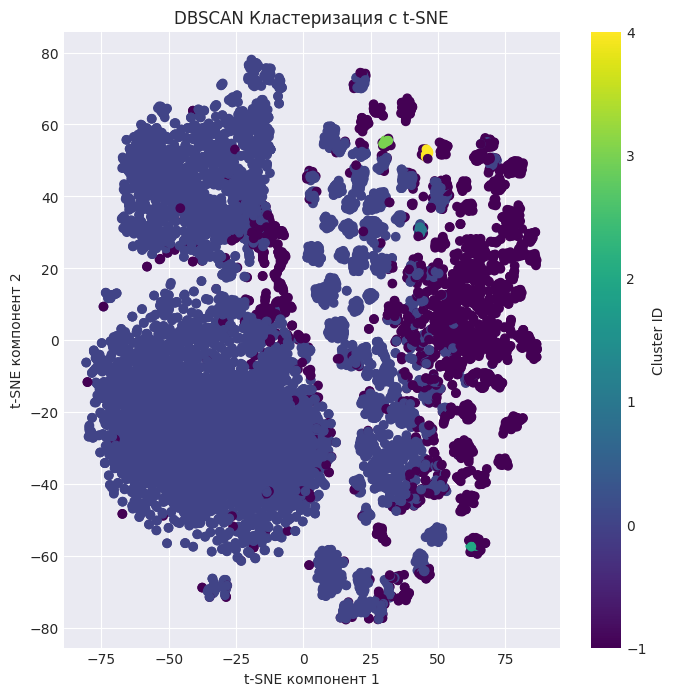

In [43]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca)

dbscan = DBSCAN(eps=15, min_samples=10)
labels = dbscan.fit_predict(X_pca)

plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', marker='o')
plt.title("DBSCAN Кластеризация с t-SNE")
plt.colorbar(label="Cluster ID")
plt.xlabel("t-SNE компонент 1")
plt.ylabel("t-SNE компонент 2")
plt.show()